In [1]:
using FastAI
using FluxTraining

┌ Info: Precompiling FastAI [5d0beca9-ade8-49ae-ad0b-a3cf890e669f]
└ @ Base loading.jl:1313


In [199]:
dataset = Datasets.loaddataset("imagenette2-160");

method = ImageClassification(Datasets.loadclasses("imagenette2-160"), (160, 160))

dls = methoddataloaders(dataset, method)

model = methodmodel(method, Models.xresnet18());

learner = Learner(model, dls, ADAM(), methodlossfn(method), ToGPU(), Metrics(SmoothLoss(), accuracy))

Learner()

In [109]:
fit!(learner, ValidationPhase())

Epoch 1 ValidationPhase(): 100%|████████████████████████| Time: 0:00:03


┌─────────────────┬───────┬─────────┬────────────┬──────────┐
│           Phase │ Epoch │    Loss │ SmoothLoss │ Accuracy │
├─────────────────┼───────┼─────────┼────────────┼──────────┤
│ ValidationPhase │   1.0 │ 3.01754 │    2.20938 │  0.10156 │
└─────────────────┴───────┴─────────┴────────────┴──────────┘


Learner()

In [202]:
phase = FastAI.LRFinderPhase(steps = 100, β = 0.08)
fit!(learner, phase)

Epoch 1 FastAI.LRFinderPhase(1.0e-7, 10, 100, 0.08, 4, nothing):  14%  ETA: 0:00:30

┌──────────────────────┬───────┬─────────┬────────────┐
│                Phase │ Epoch │    Loss │ SmoothLoss │
├──────────────────────┼───────┼─────────┼────────────┤
│ FastAI.LRFinderPhase │   1.0 │ 2.86561 │    16.9383 │
└──────────────────────┴───────┴─────────┴────────────┘


Learner()

In [112]:
using SimplePlots

HTML{String}("  <script type=\"text/javascript\" class=\"js-plotly-script\">\n    globalComms = {};\n    demoData = {};\n\n    \$(\".js-plotly-script\").parent().css('padding', 0);\n\n    function customPlotlyReact(curPlot, curData, curLayout, curConfig) {\n      for (var i = 0; i < curData.length; i++) {\n        curData[i][\"visible\"] = true;\n        for (var j = 0; j < curPlot.data.length; j++) {\n          if ( curData[i].name !== curPlot.data[j].name ) { continue; }\n          if ( curPlot.data[j].visible !== \"legendonly\" ) { continue; }\n\n          curData[i][\"visible\"] = \"legendonly\";\n        }\n      }\n\n      Plotly.react(curPlot, curData, curLayout, curConfig);\n    }\n\n    function customPlotLoader(curCallback) {\n      if ( \$(\".js-nouislider-css\").length == 0 ) {\n        \$(\"head\").append(\n          '<link class=\"js-nouislider-css\" href=\"https://cdn.jsdelivr.net/gh/djsegal/SimplePlots.jl/dist/nouislider.min.css\" rel=\"stylesheet\">'\n        );\n      }\n\n      if ( \$(\".js-custom-css\").length == 0 ) {\n        \$(\"head\").append(\n          '<link class=\"js-custom-css\" href=\"https://cdn.jsdelivr.net/gh/djsegal/SimplePlots.jl/dist/custom.min.css\" rel=\"stylesheet\">'\n        );\n      }\n\n      if ( typeof Plotly !== \"undefined\" ) {\n        if ( typeof curCallback !== \"undefined\" ) {\n          curCallback();\n        }\n        return;\n      }\n\n      var plotlyScripts = document.getElementsByClassName(\"js-plotly-script\");\n\n      for (var i = 0; i < plotlyScripts.length; i++) {\n        var scriptParent = plotlyScripts[i].parentElement;\n        scriptParent.style.margin = \"0\";\n        scriptParent.style.padding = \"0\";\n      }\n\n      require.config({\n        paths: {\n          Plotly: \"https://cdn.plot.ly/plotly-1.53.0.min\",\n          noUiSlider: \"https://cdn.jsdelivr.net/gh/djsegal/SimplePlots.jl/dist/nouislider.min\",\n          wNumb: \"https://cdn.jsdelivr.net/gh/djsegal/SimplePlots.jl/dist/wnumb.min\"\n        }\n      });\n\n      require([\"Plotly\", \"noUiSlider\", \"wNumb\"], function(Plotly, noUiSlider, wNumb){\n        window.Plotly = Plotly;\n        window.noUiSlider = noUiSlider;\n        window.wNumb = wNumb;\n\n        if ( typeof curCallback !== \"undefined\" ) {\n          curCallback();\n        }\n\n        \$(\"head\").append(\$(\".js-plotly-script\"));\n        \$(\"head .js-plotly-script:not(:first)\").remove();\n        \$(\"body .js-plotly-script\").remove();\n      });\n    }\n\n    \$(document).ready(customPlotLoader);\n    customPlotLoader();\n  </script>\n")

In [181]:
start = 0.001
end_ = 10
start * (end_/start)^1


10.0

In [203]:
SimplePlots.plot(phase.result.lrs, phase.result.losses, xscale=:log)

HTML{String}("  <div id=\"js-plot-7c9199b3-673a-4866-8b18-eb331cba4326\" style=\"width:600px;height:400px;\"></div>\n  <script class=\"js-new-plot-script\">\n    var anonFunc = function () {\n      plotDiv = document.getElementById('js-plot-7c9199b3-673a-4866-8b18-eb331cba4326');\n      if ( plotDiv === null ) { return; }\n      if ( plotDiv.childElementCount > 0 ) { return; }\n\n      Plotly.newPlot(\n        plotDiv,\n        [{\"line\":{\"color\":\"#636EFA\"},\"mode\":\"lines\",\"x\":[1.2022645e-7,1.4454398e-7,1.7378008e-7,2.089296e-7,2.5118865e-7,3.019952e-7,3.6307804e-7,4.3651582e-7,5.2480743e-7,6.3095735e-7,7.585776e-7,9.120108e-7,1.0964782e-6,1.3182567e-6,1.5848932e-6,1.9054607e-6,2.2908675e-6,2.7542287e-6,3.3113113e-6,3.9810716e-6,4.786301e-6,5.7543994e-6,6.9183097e-6,8.317637e-6,1.0e-5,1.2022644e-5,1.4454397e-5,1.7378008e-5,2.0892961e-5,2.5118865e-5,3.0199517e-5,3.6307807e-5,4.3651584e-5,5.2480747e-5,6.309574e-5,7.585776e-5,9.120109e-5,0.00010964782,0.00013182567,0.00015848932,0.00019054607,0.00022908677,0.00027542288,0.00033113113,0.00039810716,0.0004786301,0.00057543995,0.000691831,0.0008317638,0.001,0.0012022645,0.0014454398,0.0017378008,0.0020892962,0.0025118864,0.0030199517,0.0036307806,0.0043651583,0.0052480744,0.0063095735,0.0075857756,0.009120109,0.010964782,0.013182567,0.015848933,0.019054607,0.022908676,0.027542287,0.03311311,0.039810717,0.04786301,0.057543993,0.0691831,0.083176374,0.1,0.12022644,0.14454398,0.17378008,0.20892961,0.25118864,0.30199516,0.36307806,0.43651584,0.52480745,0.63095737,0.7585776,0.91201085,1.0964782,1.3182567,1.5848932,1.9054607,2.2908676,2.7542286],\"y\":[2.5167599,2.2320144,2.4454868,2.6576657,2.1387916,2.4620738,2.6061733,2.6880817,2.6384275,2.3582916,2.6012726,2.4320178,2.7836168,2.52802,2.502649,2.4004567,2.638181,2.3619833,2.3336816,2.3098137,2.468624,2.517022,2.4404716,2.5672183,2.6014516,2.7462997,2.5594354,2.5789518,2.622253,2.417955,2.5031338,2.4924507,2.1993468,2.3843262,2.401427,2.7026982,2.6724582,2.252953,2.5753617,2.1890874,2.2918694,2.076436,2.3212354,2.3768234,2.1373723,2.2005348,2.0965233,2.1818995,1.9782852,2.0849872,1.9676919,1.978767,2.0921087,2.2147865,2.397207,1.8880293,2.0115352,1.9452621,2.3409343,2.4804134,2.2038193,2.325563,3.5687518,2.6334457,3.0667202,3.1004186,2.981547,2.7047307,3.3863864,2.7884736,3.4553719,3.0910618,2.940474,5.7099524,2.390851,2.9324222,3.9302115,3.5907443,2.8227475,2.5749965,2.7245138,2.538578,2.5563087,2.3119373,3.6827462,2.8222759,3.7917924,4.2399597,4.4592876,6.911332,3.8928487,3.693502,18.087011]}],\n        {\"showlegend\":true,\"xaxis\":{\"autorange\":true,\"type\":\"log\",\"exponentformat\":\"power\"},\"annotations\":[],\"yaxis\":{\"autorange\":true,\"type\":\"linear\"},\"shapes\":[],\"legend\":{}},\n        {\"responsive\":true}\n      );\n    }\n\n    customPlotLoader(anonFunc);\n  </script>\n")

In [196]:
SimplePlots.plot(phase.result.lrs, phase.result.losses, xscale=:log)

HTML{String}("  <div id=\"js-plot-e4ca3326-db62-4092-bff6-98fc143948e8\" style=\"width:600px;height:400px;\"></div>\n  <script class=\"js-new-plot-script\">\n    var anonFunc = function () {\n      plotDiv = document.getElementById('js-plot-e4ca3326-db62-4092-bff6-98fc143948e8');\n      if ( plotDiv === null ) { return; }\n      if ( plotDiv.childElementCount > 0 ) { return; }\n\n      Plotly.newPlot(\n        plotDiv,\n        [{\"line\":{\"color\":\"#636EFA\"},\"mode\":\"lines\",\"x\":[1.0964782e-7,1.2022645e-7,1.3182567e-7,1.4454398e-7,1.5848931e-7,1.7378008e-7,1.9054607e-7,2.089296e-7,2.2908677e-7,2.5118865e-7,2.7542288e-7,3.019952e-7,3.3113113e-7,3.6307804e-7,3.9810718e-7,4.3651582e-7,4.786301e-7,5.2480743e-7,5.754399e-7,6.3095735e-7,6.9183096e-7,7.585776e-7,8.3176377e-7,9.120108e-7,1.0e-6,1.0964782e-6,1.2022645e-6,1.3182567e-6,1.4454398e-6,1.5848932e-6,1.7378009e-6,1.9054607e-6,2.0892962e-6,2.2908675e-6,2.5118864e-6,2.7542287e-6,3.0199517e-6,3.3113113e-6,3.6307806e-6,3.9810716e-6,4.3651585e-6,4.786301e-6,5.2480746e-6,5.7543994e-6,6.3095736e-6,6.9183097e-6,7.5857756e-6,8.317637e-6,9.120108e-6,1.0e-5,1.0964782e-5,1.2022644e-5,1.3182567e-5,1.4454397e-5,1.5848931e-5,1.7378008e-5,1.9054607e-5,2.0892961e-5,2.2908676e-5,2.5118865e-5,2.7542286e-5,3.0199517e-5,3.3113112e-5,3.6307807e-5,3.981072e-5,4.3651584e-5,4.786301e-5,5.2480747e-5,5.7543995e-5,6.309574e-5,6.9183094e-5,7.585776e-5,8.3176375e-5,9.120109e-5,0.0001,0.00010964782,0.00012022645,0.00013182567,0.00014454397,0.00015848932,0.00017378008,0.00019054607,0.00020892962,0.00022908677,0.00025118864,0.00027542288,0.00030199517,0.00033113113,0.00036307806,0.00039810716,0.00043651584,0.0004786301,0.0005248075,0.00057543995,0.00063095737,0.000691831,0.0007585776,0.0008317638,0.00091201084,0.001,0.0010964782,0.0012022645,0.0013182567,0.0014454398,0.0015848932,0.0017378008,0.0019054607,0.0020892962,0.0022908677,0.0025118864,0.0027542287,0.0030199517,0.0033113111,0.0036307806,0.0039810715,0.0043651583,0.004786301,0.0052480744,0.0057543996,0.0063095735,0.0069183097,0.0075857756,0.008317637,0.009120109,0.01,0.010964782,0.012022644,0.013182567,0.014454397,0.015848933,0.017378008,0.019054607,0.020892961,0.022908676,0.025118865,0.027542287,0.030199517,0.03311311,0.036307804,0.039810717,0.043651585,0.04786301,0.052480746,0.057543993,0.06309573,0.0691831,0.07585776,0.083176374,0.09120108,0.1,0.10964782,0.12022644,0.13182567,0.14454398,0.15848932,0.17378008,0.19054607,0.20892961,0.22908677,0.25118864,0.27542287,0.30199516,0.33113113,0.36307806,0.39810717,0.43651584,0.4786301,0.52480745,0.57543993,0.63095737,0.691831,0.7585776,0.83176374,0.91201085,1.0,1.0964782,1.2022644,1.3182567,1.4454398],\"y\":[2.707675,2.4834244,2.302768,2.5310173,2.9446445,2.4759455,2.330604,2.4347582,2.2999334,2.3708794,2.6317418,2.541554,2.6062202,2.42644,2.375873,2.3673663,2.431928,2.3619826,2.606194,2.7159603,2.608813,2.4201412,2.5538793,2.4649181,2.3553686,2.5403943,2.315298,2.6905694,2.3528767,2.3376594,2.238482,2.5909934,2.5772164,2.5556672,2.5754461,2.7224412,2.775315,2.7722409,2.3944206,2.6198797,2.6325555,2.4442315,2.5468512,2.2650242,2.4948628,2.6077867,2.4664395,2.3505857,2.369568,2.6702976,2.3783526,2.576055,2.3625054,2.5316963,2.2725363,2.446247,2.422706,2.7092035,2.8425205,2.5828362,2.3513641,2.3410306,2.6052613,2.492902,2.3833175,2.5781965,2.4673715,2.6377838,2.3936806,2.4072194,2.314928,2.357541,2.4671965,2.1355653,2.418276,2.0284555,2.2951202,2.2637582,2.4906397,2.273815,2.5974004,2.296301,2.0719483,2.0486379,1.8763319,1.8702772,2.1822898,2.1886141,2.1820893,1.8066785,2.0812001,1.8107686,1.9889746,1.8297445,1.785892,1.7828807,1.8630581,1.8782935,2.2538106,2.392701,1.8049634,2.310424,1.9431118,1.6764247,1.9782748,1.9150946,1.9789441,2.2041698,1.8438326,2.3482933,1.635695,2.2290778,1.9834157,1.712801,1.6494033,1.9441786,2.4246593,2.3565292,2.3323164,2.3978453,1.8655994,3.0312662,2.4594164,2.1566205,2.1734154,2.56454,2.3930316,2.6846976,2.98951,2.4482718,2.6517467,2.7301092,2.267336,2.4412014,3.1663523,

In [99]:
fit!(learner, ValidationPhase())

Epoch 2 ValidationPhase(): 100%|████████████████████████| Time: 0:00:02


┌─────────────────┬───────┬─────────┬────────────┬──────────┐
│           Phase │ Epoch │    Loss │ SmoothLoss │ Accuracy │
├─────────────────┼───────┼─────────┼────────────┼──────────┤
│ ValidationPhase │   2.0 │ 70185.3 │    55947.3 │   0.0828 │
└─────────────────┴───────┴─────────┴────────────┴──────────┘


Learner()

In [28]:
using Animations

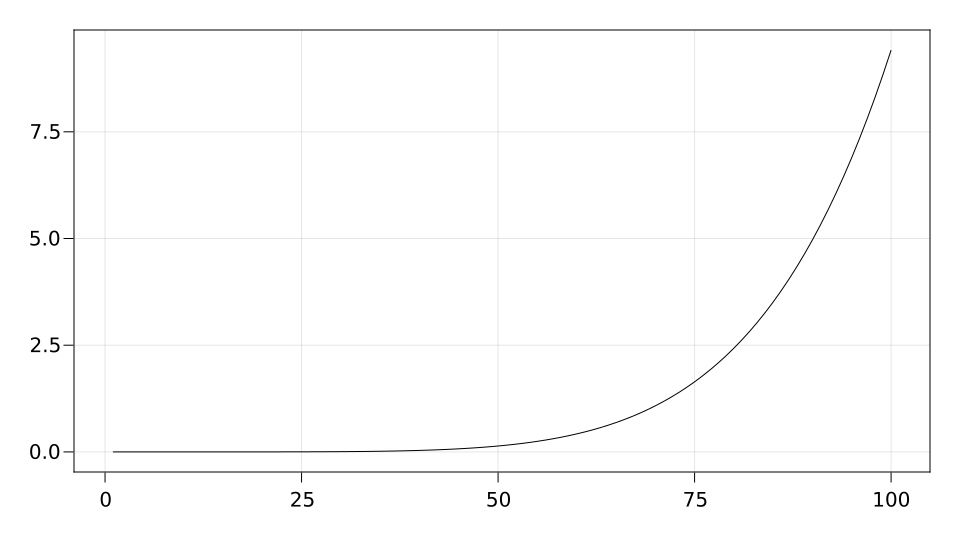

In [59]:
anim = Animation([0, 100], [1e-7, 10], Animations.polyin(6))
xs = 0:99
ys = at.(anim, xs)
lines((ys))

In [60]:
ys

100-element Vector{Float64}:
 1.0e-7
 1.0000999999989999e-7
 1.006399999936e-7
 1.072899999271e-7
 1.409599995904e-7
 2.5624999843750006e-7
 5.665599953344e-7
 1.2764899882351009e-6
 2.7214399737856006e-6
 5.4144099468558985e-6
 1.0099999900000005e-5
 1.7815609822843903e-5
 2.9959839701401594e-5
 ⋮
 4.644040921399593
 4.969812959911872
 5.314410046855901
 5.678692563623077
 6.063550052804502
 6.469901869790984
 6.89869784157302
 7.35091893274081
 7.82757791868422
 8.329720065992799
 8.85842382005576
 9.414801499861985

In [44]:
phase.result.lrs

2-element Vector{Float32}:
 0.13815019
 0.275346

In [15]:
using CairoMakie

In [16]:
phase.result.losses

100-element Vector{Float32}:
 2.6275306
 2.471809
 2.1641283
 2.5683484
 2.3907127
 2.6247745
 2.1055207
 2.457303
 2.5445619
 2.7398293
 2.786422
 2.6675625
 2.4327414
 ⋮
 2.7605398
 2.0860941
 2.2716177
 2.7597816
 2.8109503
 2.4862947
 2.893456
 2.3609295
 2.3563485
 2.5540743
 2.83923
 2.4966836

In [ ]:
fitonecycle!(learner, 2)

In [49]:
finetune!(learner, 1)

Epoch 1 TrainingPhase():  32%|████████▍                 |  ETA: 0:00:21

LoadError: InterruptException:

## `lrfind!`

In [3]:
struct LRFinderResult{T}
    losses::Vector{T}
    lrs::Vector{T}
    steepest::T
    mindiv10::T
end

function LRFinderResult(losses::Vector{T}, lrs) where T
    return LRFinderResult(losses, lrs, zero(T), zero(T))
end

LRFinderResult

In [35]:
mutable struct LRFinderPhase <: FluxTraining.Phases.AbstractTrainingPhase
    startlr
    endlr
    steps
    β
    divergefactor
    result
end

function LRFinderPhase(; startlr = 1e-7, endlr = 10, steps = 100, β = 0.02, divergefactor = 4, result = nothing)
    return LRFinderPhase(startlr, endlr, steps, β, divergefactor, result)
end

LoadError: invalid redefinition of constant LRFinderPhase

In [49]:
using CairoMakie

In [91]:
phase = LRFinderPhase()

LRFinderPhase(1.0e-7, 10, 100, 0.02, 4, nothing)

In [78]:
FluxTraining.initlearner!(learner, [TrainingPhase()])

In [85]:
learner.cbstate

FluxTraining.PropDict{Any}(Dict{Symbol, Any}(:metricsstep => DataStructures.DefaultDict{FluxTraining.Phases.Phase, ValueHistories.MVHistory, FluxTraining.var"#35#37"}(), :history => DataStructures.DefaultDict{FluxTraining.Phases.Phase, FluxTraining.History, FluxTraining.var"#44#45"}(LRFinderPhase(10, 10, 100, 0.02, 4, nothing) => FluxTraining.History(0, 0, 0, 0)), :metricsepoch => DataStructures.DefaultDict{FluxTraining.Phases.Phase, ValueHistories.MVHistory, FluxTraining.var"#36#38"}()))

In [92]:
result = FluxTraining.fit!(learner, phase)

LoadError: ArgumentError: The specified arguments are of incompatible type

In [10]:
using Animations

In [22]:
using FluxTraining.Events
using FluxTraining: handle

In [60]:
expoutfunction FluxTraining.fitepochphase!(
        learner::Learner,
        phase::LRFinderPhase)
    
    dataiter = FluxTraining.getdataiter(TrainingPhase(), learner)
    if dataiter === nothing
        throw(CancelEpochException("No data found for phase $(typeof(phase))"))
    end
    
    metric = SmoothLoss(phase.β)
    metricscb = Metrics(metric)
    losses = Float32[]
    lrs = Float32[]
    
    FastAI.withfields(
        learner,
        model = (FluxTraining.model!, deepcopy(cpu(learner.model))),
        optimizer = deepcopy(learner.optimizer)
        ) do
            
        FastAI.withcallbacks(learner, metricscb, Scheduler()) do
            schedule = Schedule([0, phase.steps], [phase.startlr, phase.endlr], Animations.expin(2))
            FastAI.setschedules!(learner, phase, LearningRate => schedule)
            bestloss = Inf

            handle(EpochBegin(), learner, phase)
            for (i, batch) in zip(1:phase.steps, dataiter)
                FluxTraining.fitbatch!(learner, batch, phase)

                loss = FluxTraining.stepvalue(metric)
                bestloss = min(bestloss, loss)
                push!(losses, loss)
                push!(lrs, Animations.at(schedule, i))

                # Stop if loss is diverging
                if loss > bestloss * phase.divergefactor
                    break
                end
            end
            handle(EpochEnd(), learner, phase)
        end
    end
    
    #phase.result = LRFinderResult(losses, lrs)
    return LRFinderResult(losses, lrs)
end